In [1]:
# reference example
from nequip.data import dataset_from_config
from nequip.utils import Config
from nequip.utils.misc import get_default_device_name
from nequip.utils.config import _GLOBAL_ALL_ASKED_FOR_KEYS

from nequip.model import model_from_config


default_config = dict(
    root="./",
    tensorboard=False,
    wandb=False,
    model_builders=[
        "SimpleIrrepsConfig",
        "EnergyModel",
        "PerSpeciesRescale",
        "StressForceOutput",
        "RescaleEnergyEtc",
    ],
    dataset_statistics_stride=1,
    device=get_default_device_name(),
    default_dtype="float64",
    model_dtype="float32",
    allow_tf32=True,
    verbose="INFO",
    model_debug_mode=False,
    equivariance_test=False,
    grad_anomaly_mode=False,
    gpu_oom_offload=False,
    append=False,
    warn_unused=False,
    _jit_bailout_depth=2,  # avoid 20 iters of pain, see https://github.com/pytorch/pytorch/issues/52286
    # Quote from eelison in PyTorch slack:
    # https://pytorch.slack.com/archives/CDZD1FANA/p1644259272007529?thread_ts=1644064449.039479&cid=CDZD1FANA
    # > Right now the default behavior is to specialize twice on static shapes and then on dynamic shapes.
    # > To reduce warmup time you can do something like setFusionStrartegy({{FusionBehavior::DYNAMIC, 3}})
    # > ... Although we would wouldn't really expect to recompile a dynamic shape fusion in a model,
    # > provided broadcasting patterns remain fixed
    # We default to DYNAMIC alone because the number of edges is always dynamic,
    # even if the number of atoms is fixed:
    _jit_fusion_strategy=[("DYNAMIC", 3)],
    # Due to what appear to be ongoing bugs with nvFuser, we default to NNC (fuser1) for now:
    # TODO: still default to NNC on CPU regardless even if change this for GPU
    # TODO: default for ROCm?
    _jit_fuser="fuser1",
)

# All default_config keys are valid / requested
_GLOBAL_ALL_ASKED_FOR_KEYS.update(default_config.keys())

/Users/temporary/anaconda3/envs/torch_mkl/lib/python3.10/site-packages/nequip/__init__.py:20: UserWarning: !! PyTorch version 2.0.0 found. Upstream issues in PyTorch versions 1.13.* and 2.* have been seen to cause unusual performance degredations on some CUDA systems that become worse over time; see https://github.com/mir-group/nequip/discussions/311. The best tested PyTorch version to use with CUDA devices is 1.11; while using other versions if you observe this problem, an unexpected lack of this problem, or other strange behavior, please post in the linked GitHub issue.
  warnings.warn(


In [2]:
config = Config.from_file('./configs/example.yaml', defaults=default_config)
    

dataset = dataset_from_config(config, prefix="dataset")

validation_dataset = None

dataset[0]

AtomicData(atom_types=[15, 1], cell=[3, 3], edge_cell_shift=[152, 3], edge_index=[2, 152], forces=[15, 3], pbc=[3], pos=[15, 3], total_energy=[1])

In [3]:
# Trainer
from nequip.train.trainer import Trainer

trainer = Trainer(model=None, **Config.as_dict(config))

# what is this
# to update wandb data?
config.update(trainer.params)

# = Train/test split =
trainer.set_dataset(dataset, validation_dataset)

# = Build model =
final_model = model_from_config(
    config=config, initialize=True, dataset=trainer.dataset_train
)

Torch device: cpu
/Users/temporary/Documents/GitHub/pytorch-intel-mps/torch/jit/_check.py:172: UserWarning: The TorchScript type system doesn't support instance-level annotations on empty non-base types in `__init__`. Instead, either 1) use a type annotation in the class body, or 2) wrap the type in `torch.jit.Attribute`.
  warnings.warn("The TorchScript type system doesn't support "
Replace string dataset_per_atom_total_energy_mean to -11319.556640625
Atomic outputs are scaled by: [H, C: None], shifted by [H, C: -11319.556641].
Replace string dataset_forces_rms to 30.621034622192383
Initially outputs are globally scaled by: 30.621034622192383, total_energy are globally shifted by None.


In [4]:
(96 + 64)*64/2

5120.0

In [5]:
final_model

GraphModel(
  (model): RescaleOutput(
    (model): StressOutput(
      (func): SequentialGraphNetwork(
        (one_hot): OneHotAtomEncoding()
        (spharm_edges): SphericalHarmonicEdgeAttrs(
          (sh): SphericalHarmonics()
        )
        (radial_basis): RadialBasisEdgeEncoding(
          (basis): BesselBasis()
          (cutoff): PolynomialCutoff()
        )
        (chemical_embedding): AtomwiseLinear(
          (linear): Linear(2x0e -> 32x0e | 64 weights)
        )
        (layer0_convnet): ConvNetLayer(
          (equivariant_nonlin): Gate (96x0e+32x1o+32x2e -> 32x0e+32x2e+32x1o)
          (conv): InteractionBlock(
            (linear_1): Linear(32x0e -> 32x0e | 1024 weights)
            (fc): FullyConnectedNet[8, 64, 64, 96]
            (tp): TensorProduct(32x0e x 1x0e+1x1o+1x2e -> 32x0e+32x1o+32x2e | 96 paths | 96 weights)
            (linear_2): Linear(32x0e+32x1o+32x2e -> 96x0e+32x1o+32x2e | 5120 weights)
            (sc): FullyConnectedTensorProduct(32x0e x 2x0e -> 

In [6]:

from nequip.data import AtomicData

out = final_model(AtomicData.to_AtomicDataDict(dataset[0]))

# Dets AtomicDataDict as input and returns AtomicDataDict as output
type(out)

dict

## OneHotEncoding

In [197]:
from vladimir import GraphModuleMixin
from vladimir import OneHotAtomEncoding

In [198]:
def get_diff_dicts(dict1, dict2):
    set1 = set(dict1.items())
    set2 = set(dict2.items())
    diff = set1 ^ set2
    
    #out = sum([diff[key].sum() for key in diff])
    return diff

def get_diff_out(dict1, dict2):
    
    print()
    out = sum([((dict1[key] - dict2[key])**2).sum() for key in dict1 if dict1[key].dtype == torch.float32])
    return out

def print_diff(ir_1, ir_2):

    print('Irreps in')
    print(ir_1)
    print('Irreps out')
    print(ir_2)
    print('Irreps diff')
    print(get_diff_dicts(ir_1, ir_2))

In [199]:
# One hot encoding of the types
data = AtomicData.to_AtomicDataDict(dataset[0])



one_hot = OneHotAtomEncoding(2)

data1 = one_hot(data)


print_diff(one_hot.irreps_in, one_hot.irreps_out)

Irreps in
{'pos': 1x1o, 'edge_index': None}
Irreps out
{'pos': 1x1o, 'edge_index': None, 'node_attrs': 2x0e, 'node_features': 2x0e}
Irreps diff
{('node_attrs', 2x0e), ('node_features', 2x0e)}


In [200]:
from nequip.data import AtomicDataDict
import torch
import numpy as np
from e3nn.o3 import Irreps
from copy import deepcopy

print(AtomicDataDict.ATOM_TYPE_KEY)

data_my = AtomicData.to_AtomicDataDict(dataset[0])



irreps_in_my = {'pos': Irreps('1x1o'), 'edge_index': None}
irreps_out_my = deepcopy(irreps_in_my)

types = data['atom_types'].squeeze(-1)
num_types = len(np.unique(types))

encoded_types = torch.nn.functional.one_hot(types, 
                                            num_classes = num_types).to(dtype = torch.float32)

from copy import deepcopy

data1_my = deepcopy(data_my)

data1_my['node_attrs'] = encoded_types
data1_my['node_features'] = encoded_types

irreps_out_my['node_attrs'] = Irreps([(num_types, (0, 1))])
irreps_out_my['node_features'] = irreps_out_my['node_attrs']


print_diff(irreps_in_my, irreps_out_my)

atom_types
Irreps in
{'pos': 1x1o, 'edge_index': None}
Irreps out
{'pos': 1x1o, 'edge_index': None, 'node_attrs': 2x0e, 'node_features': 2x0e}
Irreps diff
{('node_attrs', 2x0e), ('node_features', 2x0e)}


In [201]:
print("Irreps in")
print(get_diff_dicts(one_hot.irreps_in, irreps_in_my))

print("Irreps out")
print(get_diff_dicts(one_hot.irreps_out, irreps_out_my))

print('Numerical difference after embedding')
get_diff_out(data1_my, data1)

Irreps in
set()
Irreps out
set()
Numerical difference after embedding



tensor(0.)

## AtomwiseLinear

In [202]:
one_hot.irreps_out['node_features']

2x0e

In [203]:
from vladimir import AtomwiseLinear
from e3nn import o3

torch.manual_seed(32)

al = AtomwiseLinear(irreps_in=one_hot.irreps_out, irreps_out=o3.Irreps([(32, (0, 1))]))

data2 = al(data1)

print_diff(al.irreps_in, al.irreps_out)

Irreps in
{'pos': 1x1o, 'edge_index': None, 'node_attrs': 2x0e, 'node_features': 2x0e}
Irreps out
{'pos': 1x1o, 'edge_index': None, 'node_attrs': 2x0e, 'node_features': 32x0e}
Irreps diff
{('node_features', 2x0e), ('node_features', 32x0e)}


In [204]:
torch.manual_seed(32)

from e3nn import o3
from e3nn.o3 import Linear

irreps2_in_my = irreps_out_my
irreps2_out_my = deepcopy(irreps_out_my)


from copy import deepcopy

field = 'node_features'

irreps_in_L = irreps2_in_my[field]
irreps_out_L = o3.Irreps([(32, (0, 1))])

data2_my = deepcopy(data1_my)

data2_my[field] = Linear(irreps_in = irreps_in_L, irreps_out = irreps_out_L)(data1_my[field])

irreps2_out_my[field] = irreps_out_L


print_diff(irreps2_in_my, irreps2_out_my)

Irreps in
{'pos': 1x1o, 'edge_index': None, 'node_attrs': 2x0e, 'node_features': 2x0e}
Irreps out
{'pos': 1x1o, 'edge_index': None, 'node_attrs': 2x0e, 'node_features': 32x0e}
Irreps diff
{('node_features', 2x0e), ('node_features', 32x0e)}


In [205]:
print("Irreps in")
print(get_diff_dicts(al.irreps_in, irreps2_in_my))

print("Irreps out")
print(get_diff_dicts(al.irreps_out, irreps2_out_my))

print('Numerical difference after embedding')
get_diff_out(data2_my, data2)
print(data2_my['node_features'][0])
print(data2['node_features'][0])

Irreps in
set()
Irreps out
set()
Numerical difference after embedding

tensor([ 0.5214, -0.4426,  0.2691,  0.5466,  1.2538,  0.1392,  0.4557,  1.0140,
         1.3806, -0.3958, -1.2060,  0.6447,  0.3683, -0.7450,  0.0168,  1.0373,
         0.8198,  0.4745, -1.2909, -0.5983,  0.9319, -0.4998,  0.8673,  0.0576,
         0.7676,  0.4229, -0.5004,  0.3736, -0.0136, -0.0590, -0.4015,  0.1887],
       grad_fn=<SelectBackward0>)
tensor([ 0.5214, -0.4426,  0.2691,  0.5466,  1.2538,  0.1392,  0.4557,  1.0140,
         1.3806, -0.3958, -1.2060,  0.6447,  0.3683, -0.7450,  0.0168,  1.0373,
         0.8198,  0.4745, -1.2909, -0.5983,  0.9319, -0.4998,  0.8673,  0.0576,
         0.7676,  0.4229, -0.5004,  0.3736, -0.0136, -0.0590, -0.4015,  0.1887],
       grad_fn=<SelectBackward0>)


### Radial Basis Encoding

In [206]:
from vladimir import RadialBasisEdgeEncoding
from e3nn import o3

torch.manual_seed(32)

rbe = RadialBasisEdgeEncoding(basis_kwargs={'r_max': 5}, cutoff_kwargs={'r_max': 5}, irreps_in=al.irreps_out)

data3 = rbe(data2)

print_diff(rbe.irreps_in, rbe.irreps_out)

Irreps in
{'pos': 1x1o, 'edge_index': None, 'node_attrs': 2x0e, 'node_features': 32x0e}
Irreps out
{'pos': 1x1o, 'edge_index': None, 'node_attrs': 2x0e, 'node_features': 32x0e, 'edge_embedding': 8x0e, 'edge_cutoff': 1x0e}
Irreps diff
{('edge_cutoff', 1x0e), ('edge_embedding', 8x0e)}


In [207]:
from torch import nn
import math


torch.manual_seed(32)


num_basis = 8
r_max = 5


data3_my = {key: torch.clone(data2_my[key]) for key in data2_my}
data3_my = AtomicDataDict.with_edge_vectors(data3_my, with_lengths=True)

edge_length = data3_my[AtomicDataDict.EDGE_LENGTH_KEY]

# edge length embedding
bessel_weights = (torch.linspace(start=1.0, end=num_basis, steps=num_basis) * math.pi)
bessel_weights = nn.Parameter(bessel_weights)

edge_length_embedding = 2/r_max*torch.sin(bessel_weights * edge_length.unsqueeze(-1) / r_max)/edge_length.unsqueeze(-1)

# cutoff
factor = 1/r_max
p = 6
    
x = edge_length * factor

cutoff = 1.0
cutoff = cutoff - (((p + 1.0) * (p + 2.0) / 2.0) * torch.pow(x, p))
cutoff = cutoff + (p * (p + 2.0) * torch.pow(x, p + 1.0))
cutoff = cutoff - ((p * (p + 1.0) / 2) * torch.pow(x, p + 2.0))
cutoff *= (x < 1.0)

cutoff = cutoff.unsqueeze(-1)

data3_my['edge_embedding'] = edge_length_embedding * cutoff
data3_my['edge_cutoff'] = cutoff

irreps3_in_my = deepcopy(irreps2_out_my)
irreps3_out_my = deepcopy(irreps2_out_my)

irreps3_out_my['edge_embedding'] = o3.Irreps([(num_basis, (0, 1))])
irreps3_out_my['edge_cutoff'] = o3.Irreps("1x0e")

print_diff(irreps_in_my, irreps_out_my)

Irreps in
{'pos': 1x1o, 'edge_index': None}
Irreps out
{'pos': 1x1o, 'edge_index': None, 'node_attrs': 2x0e, 'node_features': 2x0e}
Irreps diff
{('node_attrs', 2x0e), ('node_features', 2x0e)}


In [208]:
print("Irreps in")
print(get_diff_dicts(rbe.irreps_in, irreps3_in_my))

print("Irreps out")
print(get_diff_dicts(rbe.irreps_out, irreps3_out_my))

print('Numerical difference after embedding')
print(get_diff_out(data3_my, data3))
print(data3_my['edge_cutoff'].sum())
print(data3['edge_cutoff'].sum())

print(data3_my['edge_embedding'][0])
print(data3['edge_embedding'][0])

Irreps in
set()
Irreps out
set()
Numerical difference after embedding

tensor(5.7674e-14, grad_fn=<AddBackward0>)
tensor(113.1742)
tensor(113.1742)
tensor([ 0.0880, -0.0531, -0.0560,  0.0869,  0.0035, -0.0890,  0.0502,  0.0587],
       grad_fn=<SelectBackward0>)
tensor([ 0.0880, -0.0531, -0.0560,  0.0869,  0.0035, -0.0890,  0.0502,  0.0587],
       grad_fn=<SelectBackward0>)


### Spherical harmonics

In [209]:
torch.manual_seed(32)

from vladimir import SphericalHarmonicEdgeAttrs

sh = SphericalHarmonicEdgeAttrs(2, irreps_in=rbe.irreps_out)


data4 = sh(data3)

print_diff(sh.irreps_in, sh.irreps_out)

Irreps in
{'pos': 1x1o, 'edge_index': None, 'node_attrs': 2x0e, 'node_features': 32x0e, 'edge_embedding': 8x0e, 'edge_cutoff': 1x0e}
Irreps out
{'pos': 1x1o, 'edge_index': None, 'node_attrs': 2x0e, 'node_features': 32x0e, 'edge_embedding': 8x0e, 'edge_cutoff': 1x0e, 'edge_attrs': 1x0e+1x1o+1x2e}
Irreps diff
{('edge_attrs', 1x0e+1x1o+1x2e)}


In [210]:
print(AtomicDataDict.EDGE_VECTORS_KEY)
print(AtomicDataDict.EDGE_ATTRS_KEY)

edge_vectors
edge_attrs


In [211]:
from torch import nn
import math


torch.manual_seed(32)


l_max = 2
irreps_edge_sh = o3.Irreps.spherical_harmonics(2)

data4_my = {key: torch.clone(data3_my[key]) for key in data3_my}
data4_my = AtomicDataDict.with_edge_vectors(data3_my, with_lengths=False)


harm_gen = o3.SphericalHarmonics(irreps_edge_sh, True, 'component')

edge_vec = data4_my['edge_vectors']

data4_my['edge_attrs'] = harm_gen(edge_vec)


irreps4_in_my = deepcopy(irreps3_out_my)
irreps4_out_my = deepcopy(irreps3_out_my)

irreps4_out_my['edge_attrs'] = irreps_edge_sh


print_diff(irreps4_in_my, irreps4_out_my)

Irreps in
{'pos': 1x1o, 'edge_index': None, 'node_attrs': 2x0e, 'node_features': 32x0e, 'edge_embedding': 8x0e, 'edge_cutoff': 1x0e}
Irreps out
{'pos': 1x1o, 'edge_index': None, 'node_attrs': 2x0e, 'node_features': 32x0e, 'edge_embedding': 8x0e, 'edge_cutoff': 1x0e, 'edge_attrs': 1x0e+1x1o+1x2e}
Irreps diff
{('edge_attrs', 1x0e+1x1o+1x2e)}


In [212]:
print("Irreps in")
print(get_diff_dicts(sh.irreps_in, irreps4_in_my))

print("Irreps out")
print(get_diff_dicts(sh.irreps_out, irreps4_out_my))

print('Numerical difference after embedding')
print(get_diff_out(data4_my, data4))

Irreps in
set()
Irreps out
set()
Numerical difference after embedding

tensor(5.7674e-14, grad_fn=<AddBackward0>)


### Interaction Block

In [213]:
from vladimir import InteractionBlock
from e3nn import o3

torch.manual_seed(32)

ib = InteractionBlock(irreps_in = sh.irreps_out, 
                      irreps_out = '96x0e + 32x1o + 32x2e',
                      invariant_layers = 2,
                      invariant_neurons = 64)


data5 = ib(data4)

print_diff(ib.irreps_in, ib.irreps_out)

Irreps in
{'pos': 1x1o, 'edge_index': None, 'node_attrs': 2x0e, 'node_features': 32x0e, 'edge_embedding': 8x0e, 'edge_cutoff': 1x0e, 'edge_attrs': 1x0e+1x1o+1x2e}
Irreps out
{'pos': 1x1o, 'edge_index': None, 'node_attrs': 2x0e, 'node_features': 96x0e+32x1o+32x2e, 'edge_embedding': 8x0e, 'edge_cutoff': 1x0e, 'edge_attrs': 1x0e+1x1o+1x2e}
Irreps diff
{('node_features', 32x0e), ('node_features', 96x0e+32x1o+32x2e)}


In [214]:
from torch import nn
import math
from e3nn.nn import FullyConnectedNet
from e3nn.o3 import TensorProduct, Linear, FullyConnectedTensorProduct
from torch_runstats.scatter import scatter

torch.manual_seed(32)


data5_my = {key: torch.clone(data4_my[key]) for key in data4_my}


# Figuring out the irreps
irreps5_in_my = deepcopy(irreps4_out_my)
irreps5_out_my = deepcopy(irreps4_out_my)

irreps5_out_my['node_features'] = o3.Irreps('96x0e + 32x1o + 32x2e')

feature_irreps_in = irreps5_in_my['node_features']
feature_irreps_out = irreps5_out_my['node_features']
irreps_edge_attr = irreps5_in_my['edge_attrs']

irreps_mid = []
instructions = []

# instructions means stuff for multiplicities
for i, (mul, ir_in) in enumerate(feature_irreps_in):
    for j, (_, ir_edge) in enumerate(irreps_edge_attr):
        for ir_out in ir_in * ir_edge:
            if ir_out in feature_irreps_out:
                k = len(irreps_mid)
                irreps_mid.append((mul, ir_out))
                instructions.append((i, j, k, "uvu", True))


# We sort the output irreps of the tensor product so that we can simplify them
# when they are provided to the second o3.Linear
irreps_mid = o3.Irreps(irreps_mid)
irreps_mid, p, _ = irreps_mid.sort()

# Permute the output indexes of the instructions to match the sorted irreps:
instructions = [
    (i_in1, i_in2, p[i_out], mode, train)
    for i_in1, i_in2, i_out, mode, train in instructions
]
   
# Layers
# internal_weights are to use paramters for tensor product or now
# shared_weights are false means that zi = wi xi x yi opposed to zi = w xi x yi

linear_1 = Linear(
            irreps_in=feature_irreps_in,
            irreps_out=feature_irreps_in,
            internal_weights=True,
            shared_weights=True,
)

x = data5_my['node_features']
edge_src = data5_my['edge_index'][1]
edge_dst = data5_my['edge_index'][0]
   

tp = TensorProduct(
            feature_irreps_in,
            irreps_edge_attr,
            irreps_mid,
            instructions,
            shared_weights=False,
            internal_weights=False,
        )    

invariant_layers = 2
invariant_neurons = 64

# Sligtly negative nonlinear variant of relu
fc = FullyConnectedNet(
    [irreps5_in_my['edge_embedding'].num_irreps]
    + invariant_layers * [invariant_neurons]
    + [tp.weight_numel],
    torch.nn.functional.silu)


linear_2 = Linear(
            # irreps_mid has uncoallesed irreps because of the uvu instructions,
            # but there's no reason to treat them seperately for the Linear
            # Note that normalization of o3.Linear changes if irreps are coallesed
            # (likely for the better)
            irreps_in=irreps_mid.simplify(),
            irreps_out=feature_irreps_out,
            internal_weights=True,
            shared_weights=True,
        )

sc = FullyConnectedTensorProduct(
                feature_irreps_in,
                irreps5_in_my['node_attrs'],
                feature_irreps_out,
            )


weight = fc(data5_my['edge_embedding'])

sc_out = sc(x, data5_my['node_attrs'])
    
x = linear_1(x)
    

edge_features = tp(
            x[edge_src], data5_my['edge_attrs'], weight
        )

#print(tp)

# message passing from src to dst
# takes all edge features in the format (num_edges, num_features) 
# and sums over this features to the dst array
x = scatter(edge_features, edge_dst, dim=0, dim_size=len(x))


print(linear_1)
print(tp)
print(linear_2)

x = linear_2(x)

x = x + sc_out

data5_my['node_features'] = x

print_diff(irreps5_in_my, irreps5_out_my)

Linear(32x0e -> 32x0e | 1024 weights)
TensorProduct(32x0e x 1x0e+1x1o+1x2e -> 32x0e+32x1o+32x2e | 96 paths | 96 weights)
Linear(32x0e+32x1o+32x2e -> 96x0e+32x1o+32x2e | 5120 weights)
Irreps in
{'pos': 1x1o, 'edge_index': None, 'node_attrs': 2x0e, 'node_features': 32x0e, 'edge_embedding': 8x0e, 'edge_cutoff': 1x0e, 'edge_attrs': 1x0e+1x1o+1x2e}
Irreps out
{'pos': 1x1o, 'edge_index': None, 'node_attrs': 2x0e, 'node_features': 96x0e+32x1o+32x2e, 'edge_embedding': 8x0e, 'edge_cutoff': 1x0e, 'edge_attrs': 1x0e+1x1o+1x2e}
Irreps diff
{('node_features', 32x0e), ('node_features', 96x0e+32x1o+32x2e)}


In [215]:
print("Irreps in")
print(get_diff_dicts(ib.irreps_in, irreps5_in_my))

print("Irreps out")
print(get_diff_dicts(ib.irreps_out, irreps5_out_my))

print('Numerical difference after embedding')
print(get_diff_out(data5_my, data5))

Irreps in
set()
Irreps out
set()
Numerical difference after embedding

tensor(9.6702e-12, grad_fn=<AddBackward0>)


### Conv

In [216]:
from vladimir import conv
from vladimir import InteractionBlock, ConvNetLayer
from e3nn import o3

torch.manual_seed(32)

conv = ConvNetLayer(irreps_in = sh.irreps_out, 
                    feature_irreps_hidden = '32x0e + 32x1o + 32x2e',
                    convolution = InteractionBlock,
                    convolution_kwargs={'invariant_layers': 2, 
                                        'invariant_neurons': 64}
                   )


data4 = {key: torch.clone(data4_my[key]) for key in data4_my}

data6 = conv(data4)

print_diff(conv.irreps_in, conv.irreps_out)


Irreps in
{'pos': 1x1o, 'edge_index': None, 'node_attrs': 2x0e, 'node_features': 32x0e, 'edge_embedding': 8x0e, 'edge_cutoff': 1x0e, 'edge_attrs': 1x0e+1x1o+1x2e}
Irreps out
{'pos': 1x1o, 'edge_index': None, 'node_attrs': 2x0e, 'node_features': 32x0e+32x1o+32x2e, 'edge_embedding': 8x0e, 'edge_cutoff': 1x0e, 'edge_attrs': 1x0e+1x1o+1x2e}
Irreps diff
{('node_features', 32x0e), ('node_features', 32x0e+32x1o+32x2e)}


In [217]:
from torch import nn
import math
from e3nn.nn import FullyConnectedNet
from e3nn.o3 import TensorProduct, Linear, FullyConnectedTensorProduct
from torch_runstats.scatter import scatter
from vladimir import InteractionBlock
# just simple check if ir_out in ir_1 * ir_2
from nequip.utils.tp_utils import tp_path_exists
from e3nn.nn import Gate


acts = {
    "abs": torch.abs,
    "tanh": torch.tanh,
    "silu": torch.nn.functional.silu,
}

torch.manual_seed(32)


data6_my = {key: torch.clone(data4_my[key]) for key in data4_my}


# Figuring out the irreps
irreps6_in_my = deepcopy(irreps4_out_my)
irreps6_out_my = deepcopy(irreps4_out_my)

feature_irreps_hidden = '32x0e + 32x1o + 32x2e'

# make the nonlin dicts from parity ints instead of convinience strs
nonlinearity_scalars = {"e": "silu", "o": "tanh"}
nonlinearity_gates = {"e": "silu", "o": "tanh"}

nonlinearity_scalars = {
    1: nonlinearity_scalars["e"],
    -1: nonlinearity_scalars["o"],
}
nonlinearity_gates = {
    1: nonlinearity_gates["e"],
    -1: nonlinearity_gates["o"],
}

feature_irreps_hidden = o3.Irreps(feature_irreps_hidden)


edge_attr_irreps = irreps6_in_my['edge_attrs']
irreps_layer_out_prev = irreps6_in_my['node_features']

irreps_scalars = o3.Irreps(
    [
        (mul, ir)
        for mul, ir in feature_irreps_hidden
        if ir.l == 0
        and tp_path_exists(irreps_layer_out_prev, edge_attr_irreps, ir)
    ]
)

irreps_gated = o3.Irreps(
    [
        (mul, ir)
        for mul, ir in feature_irreps_hidden
        if ir.l > 0
        and tp_path_exists(irreps_layer_out_prev, edge_attr_irreps, ir)
    ]
)

irreps_layer_out = (irreps_scalars + irreps_gated).simplify()

ir = (
    "0e"
    if tp_path_exists(irreps_layer_out_prev, edge_attr_irreps, "0e")
    else "0o"
)
irreps_gates = o3.Irreps([(mul, ir) for mul, _ in irreps_gated])

# TO DO, it's not that safe to directly use the
# dictionary
# Just applies different functions for scalars and nonscalar features
# (+)_i ( phi_i (xi) ) + (+) ( phi_j (g_j) y_j)
equivariant_nonlin = Gate(
    irreps_scalars=irreps_scalars,
    act_scalars=[
        acts[nonlinearity_scalars[ir.p]] for _, ir in irreps_scalars
    ],
    irreps_gates=irreps_gates,
    act_gates=[acts[nonlinearity_gates[ir.p]] for _, ir in irreps_gates],
    irreps_gated=irreps_gated,
)

conv_irreps_out = equivariant_nonlin.irreps_in.simplify()

invariant_layers = 2
invariant_neurons = 64
ib = InteractionBlock(
            irreps_in=irreps6_in_my,
            irreps_out=conv_irreps_out,
            invariant_layers=invariant_layers,
            invariant_neurons=invariant_neurons
        )


# The output features are whatever we got in
# updated with whatever the convolution outputs (which is a full graph module)
irreps6_out_my.update(conv.irreps_out)
# but with the features updated by the nonlinearity
irreps6_out_my['node_features'] = (
    equivariant_nonlin.irreps_out
)

old_x = data6_my['node_features']
# run convolution
data6_my = ib(data6_my)
# do nonlinearity
data6_my['node_features'] = equivariant_nonlin(
    data6_my['node_features']
)


print_diff(irreps6_in_my, irreps6_out_my)

Irreps in
{'pos': 1x1o, 'edge_index': None, 'node_attrs': 2x0e, 'node_features': 32x0e, 'edge_embedding': 8x0e, 'edge_cutoff': 1x0e, 'edge_attrs': 1x0e+1x1o+1x2e}
Irreps out
{'pos': 1x1o, 'edge_index': None, 'node_attrs': 2x0e, 'node_features': 32x0e+32x1o+32x2e, 'edge_embedding': 8x0e, 'edge_cutoff': 1x0e, 'edge_attrs': 1x0e+1x1o+1x2e}
Irreps diff
{('node_features', 32x0e), ('node_features', 32x0e+32x1o+32x2e)}


In [218]:
print("Irreps in")
print(get_diff_dicts(conv.irreps_in, irreps6_in_my))

print("Irreps out")
print(get_diff_dicts(conv.irreps_out, irreps6_out_my))

print('Numerical difference after embedding')
print(get_diff_out(data6_my, data6))

Irreps in
set()
Irreps out
set()
Numerical difference after embedding

tensor(0., grad_fn=<AddBackward0>)


### Trying to replicate with e3nn

In [21]:
from e3nn import o3

FullyConnectedTensorProduct(32x0e x 2x0e -> 96x0e+32x1o+32x2e | 6144 paths | 6144 weights) needs 6144 weights


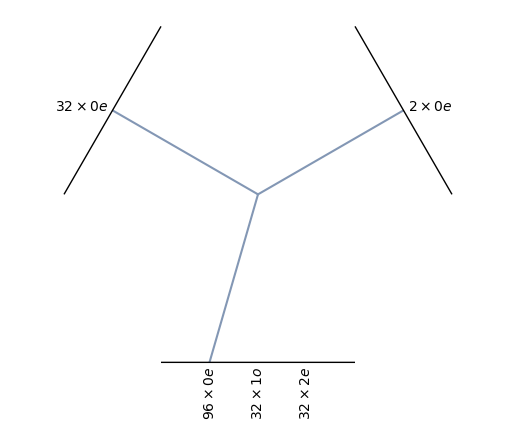

In [39]:
irreps_input = '32x0e'
irreps_sh = '2x0e'
irreps_output = '96x0e + 32x1o + 32x2e'

tp = o3.FullyConnectedTensorProduct(irreps_input, irreps_sh, irreps_output, shared_weights=True)

print(f"{tp} needs {tp.weight_numel} weights")


# No coupling to other than 0
tp.visualize();

FullyConnectedTensorProduct(32x0e+32x2e+32x1o x 2x0e -> 160x0e+32x1o+32x1e+32x2o+32x2e | 14336 paths | 14336 weights) needs 14336 weights


/Users/temporary/Documents/GitHub/pytorch-intel-mps/torch/jit/_check.py:172: UserWarning: The TorchScript type system doesn't support instance-level annotations on empty non-base types in `__init__`. Instead, either 1) use a type annotation in the class body, or 2) wrap the type in `torch.jit.Attribute`.
  warnings.warn("The TorchScript type system doesn't support "


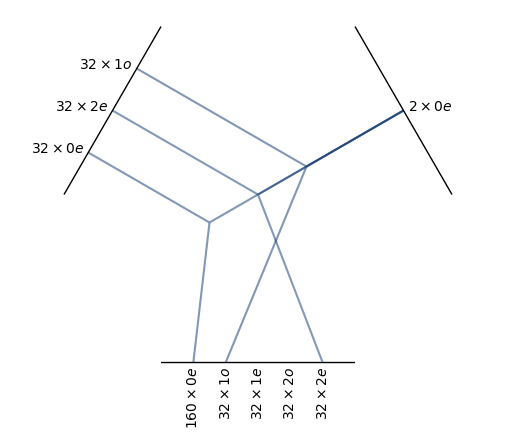

In [42]:
irreps_input = "32x0e+32x2e+32x1o"
irreps_sh = "2x0e"
irreps_output = "160x0e+32x1o+32x1e+32x2o+32x2e"


tp = o3.FullyConnectedTensorProduct(irreps_input, irreps_sh, irreps_output, shared_weights=True)

print(f"{tp} needs {tp.weight_numel} weights")


# No coupling to other than 0
tp.visualize();

In [41]:
tp.weight

Parameter containing:
tensor([ 0.4269,  0.4144,  0.6796,  ...,  0.4213, -0.1014, -1.6700],
       requires_grad=True)